In [1]:
import pandas as pd

In [25]:
data_dict = {'person_id':[], 'text':[], 'label1':[], 'label2':[]}
data_dict

{'person_id': [], 'text': [], 'label1': [], 'label2': []}

In [26]:
with open ('germeval2018.training.txt', 'r', encoding="utf8") as f:
    for line in f:
        #print(line.split())
        person_flag = 0
        if line.split()[0][0] == '@':
            data_dict['person_id'].append(line.split()[0])
            person_flag = 1
        else:
            data_dict['person_id'].append("")
            
        label_count = 0
        if line.split()[-1].isupper():
            data_dict['label1'].append(line.split()[-1])
            label_count += 1
        else:
            data_dict['label1'].append("")
        if line.split()[-2].isupper():
            data_dict['label2'].append(line.split()[-2])
            label_count += 1
        else:
            data_dict['label2'].append("")
            
        data_dict['text'].append(' '.join(line.split()[person_flag:-label_count]))

In [31]:
len(data_dict['text'])

5009

In [32]:
df = pd.DataFrame(data_dict)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5009 entries, 0 to 5008
Data columns (total 4 columns):
person_id    5009 non-null object
text         5009 non-null object
label1       5009 non-null object
label2       5009 non-null object
dtypes: object(4)
memory usage: 156.6+ KB


In [35]:
df.head()

,person_id,text,label1,label2
0,@corinnamilborn,"Liebe Corinna, wir würden dich gerne als Moder...",OTHER,OTHER
1,@Martin28a,Sie haben ja auch Recht. Unser Tweet war etwas...,OTHER,OTHER
2,@ahrens_theo,fröhlicher gruß aus der schönsten stadt der we...,OTHER,OTHER
3,@dushanwegner,Amis hätten alles und jeden gewählt...nur Hill...,OTHER,OTHER
4,@spdde,kein verläßlicher Verhandlungspartner. Nachkar...,INSULT,OFFENSE


In [36]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline

In [39]:
df.label1.value_counts()

OTHER        3321
ABUSE        1022
INSULT        595
PROFANITY      71
Name: label1, dtype: int64

In [40]:
import spacy

In [41]:
import string

In [42]:
from spacy.lang.de import German
from spacy.lang.de.stop_words import STOP_WORDS

In [48]:
# Load English tokenizer, tagger, parser, NER and word vectors
parser = German()  # Includes German data

In [45]:
# Create our list of punctuation marks
punctuations = string.punctuation

In [47]:
# Create our list of stopwords
nlp = spacy.load('de_core_news_sm')
stop_words = spacy.lang.de.stop_words.STOP_WORDS

In [49]:
# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [50]:
# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

In [51]:
# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

In [52]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1))

In [53]:
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
X = df['text'] # the features we want to analyze
ylabels = df['label1'] # the labels, or answers, we want to test against

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.3)

In [57]:
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression

In [58]:
classifier = LogisticRegression(class_weight='balanced')

In [69]:
# Create pipeline using Bag of Words
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', tfidf_vector),
                 ('classifier', classifier)])

In [70]:
# model generation
pipe.fit(X_train,y_train)

D:\Anaconda3\envs\tflearn\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
D:\Anaconda3\envs\tflearn\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Pipeline(memory=None,
     steps=[('cleaner', <__main__.predictors object at 0x0000028A84C3B2B0>), ('vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
    ...penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])

In [71]:
from sklearn import metrics
# Predicting with a test dataset
predicted = pipe.predict(X_test)

In [72]:
# Model Accuracy
print("Logistic Regression Accuracy:",metrics.accuracy_score(y_test, predicted))

Logistic Regression Accuracy: 0.6852960745176314


In [73]:
from sklearn.metrics import confusion_matrix
#confusion_matrix(y_test, predicted)

array([[ 92,  22, 189,   0],
       [ 13,  38, 120,   2],
       [ 66,  36, 900,   1],
       [  4,   2,  18,   0]], dtype=int64)

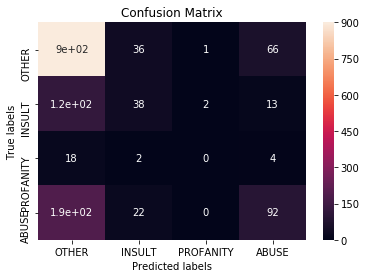

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(list(df.label1.unique())); ax.yaxis.set_ticklabels(list(df.label1.unique()));

In [110]:
print("Logistic Regression Precision:",metrics.precision_score(y_test, predicted, average='micro'))

Logistic Regression Precision: 0.6852960745176314


In [111]:
print("Logistic Regression Recall:",metrics.recall_score(y_test, predicted, average='micro'))

Logistic Regression Recall: 0.6852960745176314


In [117]:
print("Logistic Regression F1 score:",metrics.f1_score(y_test, predicted, average='micro'))

Logistic Regression F1 score: 0.6852960745176314
